In [1]:
from qiskit_aqua.components.uncertainty_models.multivariate_normal_distribution import MultivariateNormalDistribution
from qiskit_aqua.components.uncertainty_problems.fixed_income_expected_value import FixedIncomeExpVal
import matplotlib.pyplot as plt
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, execute, Aer
import numpy as np
from qiskit_aqua.algorithms import AmplitudeEstimation

# Pricing fixed-income assets

We seek to price a fixed-income asset knowing the distributions describing the relevant interest rates. The cash flows $c_t$ of the asset and the dates at which they occur are known. The total value $V$ of the asset is thus the expectation value of:

$$V = \sum_{t=1}^T \frac{c_t}{(1+r_t)^t}$$

Each cash flow is treated as a zero coupon bond with a corresponding interest rate $r_t$ that depends on its maturity. The user must specify the distribution modelling the uncertainty in each $r_t$ (possibly correlated) as well as the number of qubits he wishes to use to sample each distribution. In this example we expand the value of the asset to first order in the interest rates $r_t$. This corresponds to studying the asset in terms of its duration.

In [20]:
# can be used in case a principal component analysis has been done to derive the uncertainty model, ignored in this example.
A = np.eye(2)
b = np.zeros(2)

# specify the number of qubits that are used to represent the different dimenions of the uncertainty model
num_qubits = [2, 2]

# specify the lower and upper bounds for the different dimension
low = [0, 0]
high = [0.25, 0.1]
mu = np.zeros(2)
sigma = np.eye(2)

# construct corresponding distribution
u = MultivariateNormalDistribution(num_qubits, low, high, mu, sigma)

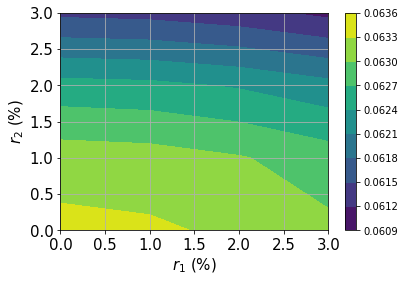

In [21]:
# plot contour of probability density function
plt.contourf(u.probabilities.reshape(2**num_qubits[0], 2**num_qubits[1]))
plt.xticks(size=15)
plt.yticks(size=15)
plt.grid()
plt.xlabel('$r_1$ (%)', size=15)
plt.ylabel('$r_2$ (%)', size=15)
plt.colorbar()
plt.show()

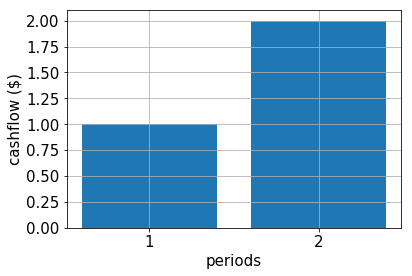

In [22]:
# specify cash flow
cf = [1.0, 2.0]
periods = range(1, len(cf)+1)

# plot cash flow
plt.bar(periods, cf)
plt.xticks(periods, size=15)
plt.yticks(size=15)
plt.grid()
plt.xlabel('periods', size=15)
plt.ylabel('cashflow ($)', size=15)
plt.show()

In [30]:
# estimate real value
cnt = 0
exact_value = 0.0
for x1 in np.linspace(low[0], high[0], pow(2, num_qubits[0])):
    for x2 in np.linspace(low[1], high[1], pow(2, num_qubits[1])):
        prob = u.probabilities[cnt]
        for t in range(len(cf)):
            # evaluate linear approximation of real value w.r.t. interest rates
            exact_value += prob * (cf[t]/pow(1 + b[t], t+1) - (t+1)*cf[t]*np.dot(A[:, t], np.asarray([x1, x2]))/pow(1 + b[t], t+2))
        cnt += 1
print('Exact value:    \t%.4f' % exact_value)

Exact value:    	2.6764


In [24]:
# specify approximation factor
c_approx = 0.05

# get fixed income circuit factory
fixed_income = FixedIncomeExpVal(u, A, b, cf, c_approx)

In [25]:
# set number of evaluation qubits (samples)
m = 2

# construct amplitude estimation 
ae = AmplitudeEstimation(m, fixed_income)

In [26]:
# result = ae.run(quantum_instance=Aer.get_backend('qasm_simulator_py'), shots=100)
result = ae.run(quantum_instance=Aer.get_backend('statevector_simulator_py'))

In [27]:
print('Exact value:    \t%.4f' % exact_value)
print('Estimated value:\t%.4f' % result['estimation'])
print('Probability:    \t%.4f' % result['max_probability'])

Exact value:    	2.6764
Estimated value:	2.6750
Probability:    	0.9910


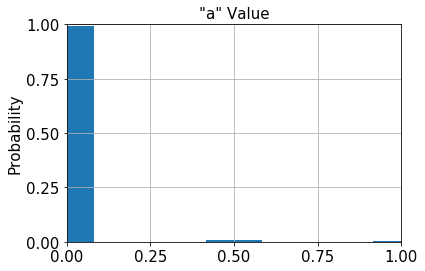

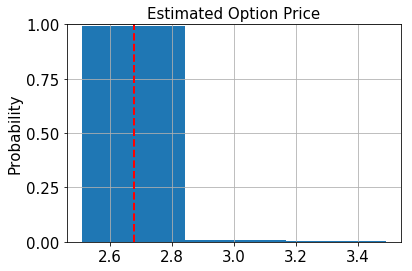

In [28]:
# plot estimated values for "a"
plt.bar(result['values'], result['probabilities'], width=0.5/len(result['probabilities']))
plt.xticks([0, 0.25, 0.5, 0.75, 1], size=15)
plt.yticks([0, 0.25, 0.5, 0.75, 1], size=15)
plt.title('"a" Value', size=15)
plt.ylabel('Probability', size=15)
plt.xlim((0,1))
plt.ylim((0,1))
plt.grid()
plt.show()

# plot estimated values for option price
plt.bar(result['mapped_values'], result['probabilities'], width=1/len(result['probabilities']))
plt.plot([exact_value, exact_value], [0,1], 'r--', linewidth=2)
plt.xticks(size=15)
plt.yticks([0, 0.25, 0.5, 0.75, 1], size=15)
plt.title('Estimated Option Price', size=15)
plt.ylabel('Probability', size=15)
plt.ylim((0,1))
plt.grid()
plt.show()